In [1]:
import warnings

import numpy as np
import pandas as pd
from IPython.display import display
from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f"Shape of df_A: {df_A.shape} and df_B: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds

bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of df_A: (27, 10) and df_B: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


# ML modeling

In [3]:
def pycaret_train(df: pd.DataFrame, target: str, model_name: str, normalize: bool = False, verbose: bool = False):
    s = setup(df, target=target, normalize=normalize, verbose=verbose)
    model = create_model(model_name, cross_validation=True, fold=5, verbose=verbose)
    final_model = tune_model(
        model,
        optimize="RMSE",
        fold=5,
        search_library="scikit-optimize",
        n_iter=50,
        search_algorithm="bayesian",
        verbose=verbose,
        tuner_verbose=verbose
    )   
    return final_model

def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

final_model = pycaret_train(df_A, "Limonene", "xgboost", normalize=True, verbose=True)
mae_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")

100%|██████████| 100/100 [00:02<00:00, 37.83it/s]

Bootstraped Mean(MAE) = 4.675334423675708


In [6]:
import pickle 
with open("../models/xgb_limonene.pkl", "wb") as f:
    pickle.dump(final_model, f)

# Explainable AI 

2024-02-02 16:54:29.992791: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 16:54:30.093413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 16:54:30.885896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 16:54:30.889991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 16:54:33.328910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

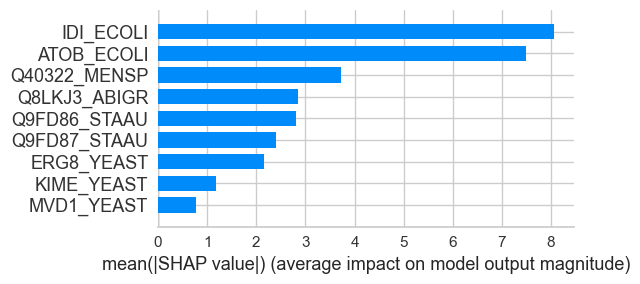

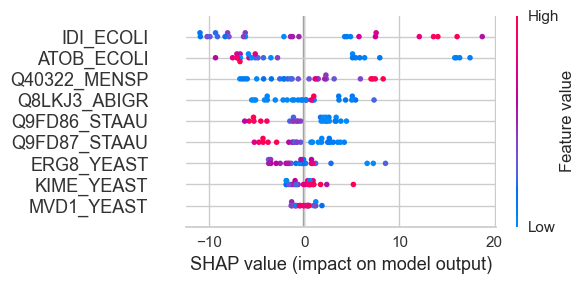

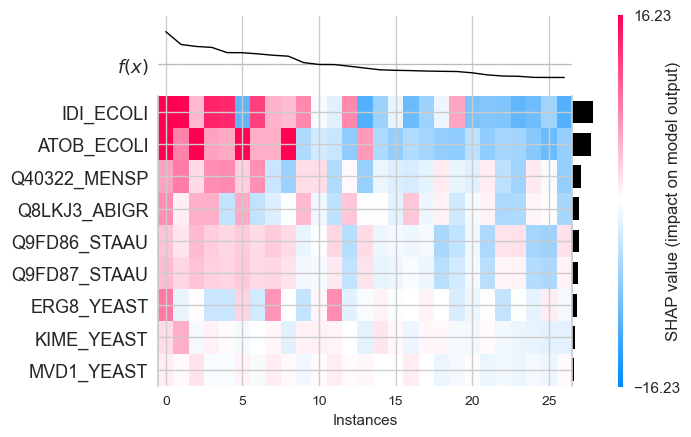

In [7]:
import shap
import matplotlib.pyplot as plt
from alibi.explainers import ALE, PartialDependence, plot_ale, plot_pd

def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


explainer = shap.Explainer(final_model.predict, df_A[INPUT_VARS])
shap_values = explainer(df_A[INPUT_VARS])
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

In [ ]:
feature = "Q40322_MENSP"
pdplot(df_A[INPUT_VARS], feature, final_model, ice=False)
shap_scatter(feature)

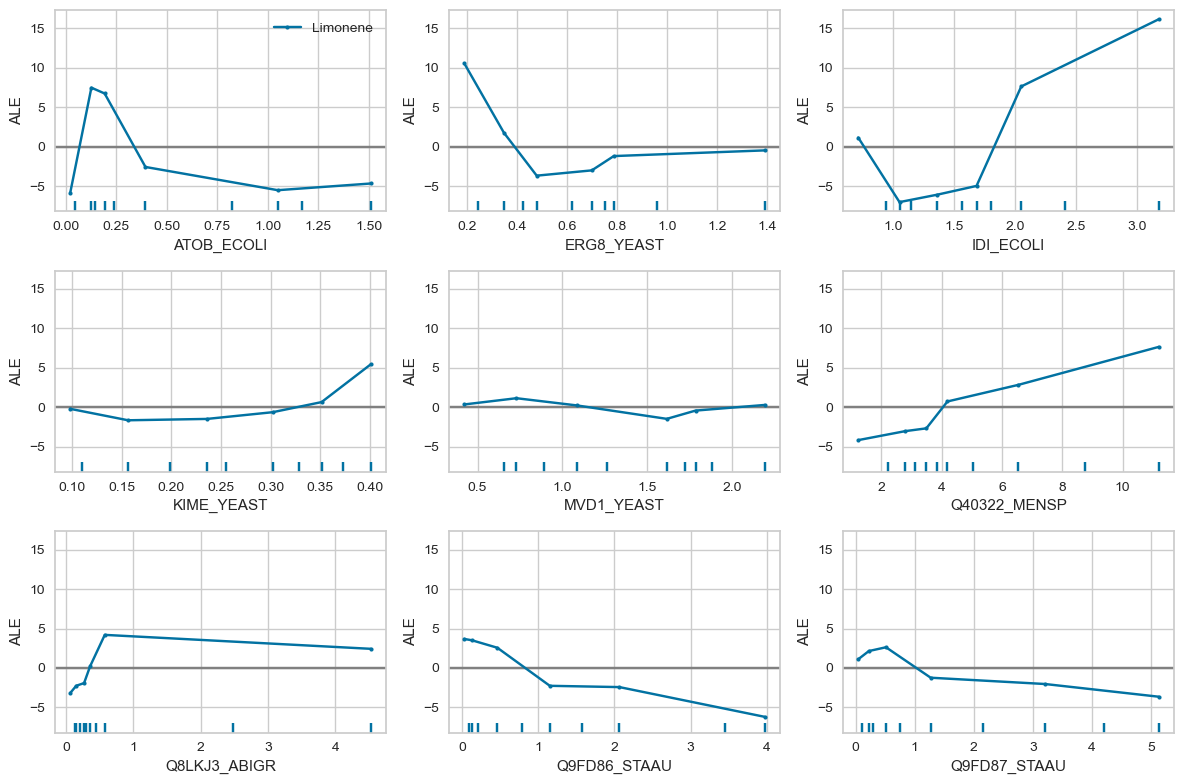

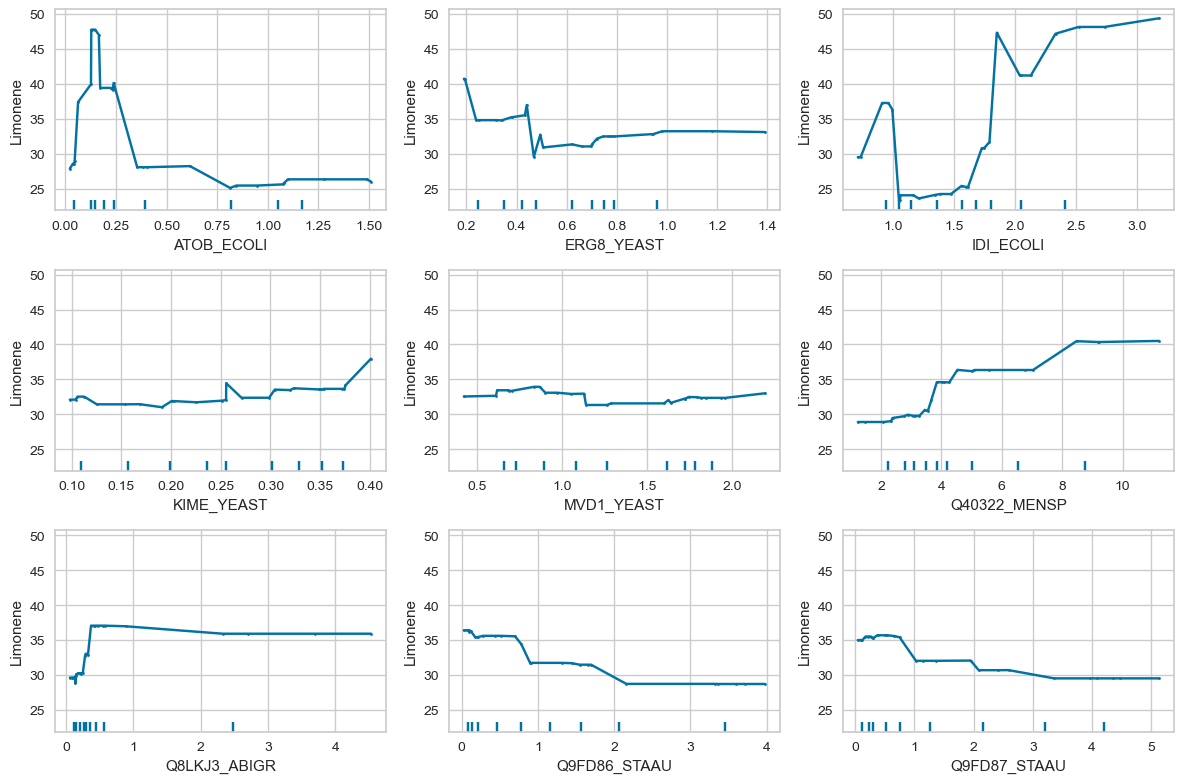

In [22]:
ale = ALE(final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS)
exp = ale.explain(X_train.values)
plot_ale(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

pdp = PartialDependence(
    predictor=final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS
)
exp = pdp.explain(X_train.values)
plot_pd(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

# Sampling

In [23]:
# original bounds
bounds

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0,0.06984,0.4676,0.06803,0.24429,0.23615,0.0,0.0,0.0
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


Create new `sampling bounds`, to generate/recommend new strain designs.

In [64]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 11
sampling_bounds["Q40322_MENSP"].loc["max"] = bounds["Q40322_MENSP"].loc["max"]

sampling_bounds["ATOB_ECOLI"].loc["min"] = 1
sampling_bounds["ATOB_ECOLI"].loc["max"] = bounds["ATOB_ECOLI"].loc["max"]

sampling_bounds["Q9FD87_STAAU"].loc["min"] = bounds["Q9FD87_STAAU"].loc["min"]
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 1.0

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = bounds["Q8LKJ3_ABIGR"].loc["min"]
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 1.0

sampling_bounds["Q9FD86_STAAU"].loc["min"] = bounds["Q9FD86_STAAU"].loc["min"]
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 0.7

sampling_bounds["MVD1_YEAST"].loc["min"] = 0.5
sampling_bounds["MVD1_YEAST"].loc["max"] = bounds["MVD1_YEAST"].loc["max"]

sampling_bounds["ERG8_YEAST"].loc["min"] = bounds["ERG8_YEAST"].loc["min"]
sampling_bounds["ERG8_YEAST"].loc["max"] = 0.6

sampling_bounds["KIME_YEAST"].loc["min"] = 0.2
sampling_bounds["KIME_YEAST"].loc["max"] = bounds["KIME_YEAST"].loc["max"]

sampling_bounds["IDI_ECOLI"].loc["min"] = 2.5
sampling_bounds["IDI_ECOLI"].loc["max"] = bounds["IDI_ECOLI"].loc["max"]

# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(10000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
4838,1.484854,0.200103,2.582855,0.429508,0.735678,12.052016,0.905240,0.056042,0.396295,77.850143
8019,1.508273,0.460218,3.103497,0.422777,1.076037,11.675015,0.994181,0.586648,0.736628,77.825714
8683,1.174972,0.213747,3.207052,0.404083,0.967051,11.312392,0.745080,0.039209,0.510345,77.721970
5736,1.021826,0.459214,2.786637,0.412463,0.908429,12.143032,0.915207,0.401639,0.472374,77.273621
4188,1.219729,0.238894,3.075818,0.410177,0.780635,11.865466,0.984239,0.142965,0.372599,77.187462
6399,1.255458,0.461540,3.246261,0.419215,0.654095,11.959711,0.395250,0.075546,0.835840,77.187225
7600,1.291577,0.225027,2.582774,0.413797,0.804020,11.624070,0.982786,0.386823,0.522797,77.151711
7867,1.611117,0.193654,3.422301,0.410146,2.050974,11.388039,0.976545,0.659233,0.782000,77.131065
496,1.600433,0.223436,3.355567,0.427487,0.841262,11.879083,0.699088,0.603979,0.503319,76.997948
3290,1.379489,0.455528,3.336252,0.424874,0.920729,11.214338,0.892126,0.642402,0.982504,76.930183


# Counterfactuals (`DiCE`)

In [66]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=4,
    desired_range=[70, 80],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

Query instance (original outcome : 102.03273010253906)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.1654,0.4407,1.8527,0.2555,1.129,4.5317,0.8922,0.2786,0.3756,102.03273



Diverse Counterfactual set (new outcome: [70, 80])


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,1.0,0.4612,2.985,-,1.5133,11.3908,0.4224,0.028,0.0607,70.19871520996094
0,1.1795,-,3.1813,0.401,2.1936,11.2037,0.2968,-,0.7488,72.14220428466797
0,1.0067,0.238,2.6552,0.2583,1.6144,11.9505,0.7037,0.1949,0.3692,70.92935180664062
0,1.4609,0.466,2.932,0.262,1.2176,11.3233,0.8647,0.5831,0.885,71.30009460449219


# PCA

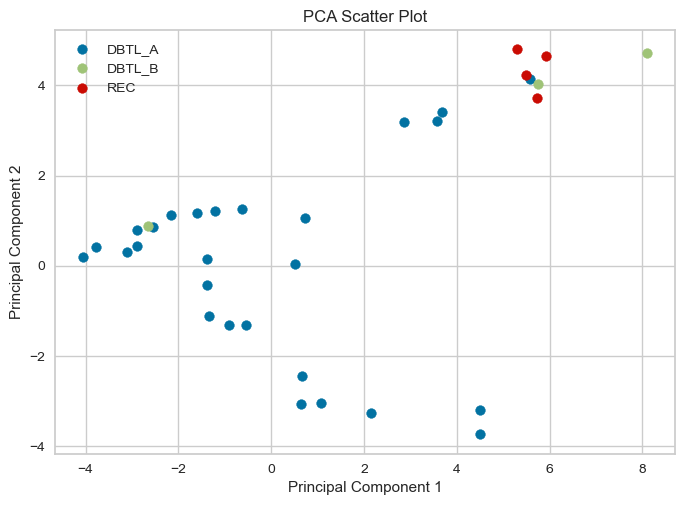

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(cf_df[INPUT_VARS])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A")
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B")
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()